In [1]:
from tensorflow.keras.models import Sequential, clone_model
from tensorflow.keras.layers import Dense, Dropout, Conv2D, MaxPooling2D, Flatten, BatchNormalization
from tensorflow.keras.callbacks import ModelCheckpoint, Callback
from tensorflow.keras.utils import plot_model, to_categorical
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split
from Sudoku_CV import centralize
from typing import Tuple
from pathlib import Path
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import cv2

plt.style.use('seaborn')

In [2]:
batch_size = 64
target_size = (40, 40)
datagen = ImageDataGenerator(rescale=1/255., validation_split=0.15)

train_generator = datagen.flow_from_directory(
    'Numbers - Original', 
    target_size=target_size, 
    batch_size=batch_size, 
    class_mode='categorical',
    color_mode='grayscale',
    subset='training',
    shuffle=True,
)

validation_generator = datagen.flow_from_directory(
    'Numbers - Original',
    target_size=target_size, 
    batch_size=batch_size, 
    class_mode='categorical',
    color_mode='grayscale',
    subset='validation',
    shuffle=True
)

Found 7776 images belonging to 9 classes.
Found 1368 images belonging to 9 classes.


In [3]:
rate = 0.25
input_shape = (40, 40, 1)

base_model = Sequential([
    Conv2D(16, (3, 3), activation='relu', input_shape=input_shape, name='ConvLayer1'),
    Dropout(rate, name='Dropout-1'),
    Conv2D(32, (5, 5), activation='relu', input_shape=input_shape, name='ConvLayer2'),
    Dropout(rate, name='Dropout-2'),
    MaxPooling2D((2, 2), name='Pooling-1'),
    Flatten(name='flatten'),
    Dense(64, activation='relu', name='FullyConnected-1'),
    Dropout(rate, name='Dropout-3'),
    Dense(9, activation='softmax', name='OutputLayer')
], name='Base-Model')

In [4]:
base_model.summary()

Model: "Base-Model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
ConvLayer1 (Conv2D)          (None, 38, 38, 16)        160       
_________________________________________________________________
Dropout-1 (Dropout)          (None, 38, 38, 16)        0         
_________________________________________________________________
ConvLayer2 (Conv2D)          (None, 34, 34, 32)        12832     
_________________________________________________________________
Dropout-2 (Dropout)          (None, 34, 34, 32)        0         
_________________________________________________________________
Pooling-1 (MaxPooling2D)     (None, 17, 17, 32)        0         
_________________________________________________________________
flatten (Flatten)            (None, 9248)              0         
_________________________________________________________________
FullyConnected-1 (Dense)     (None, 64)                5

In [5]:
plot_model(base_model, to_file='Models/base_model.png', show_shapes=True, dpi=1000)

In [6]:
gen_model = Sequential(clone_model(base_model), name='Generator-Model')
img_model = Sequential(clone_model(base_model), name='Image-Model')

In [7]:
class StopTraining(Callback):
    def on_epoch_end(self, epoch, logs=None):
        accuracy = logs.get('accuracy') or logs.get('acc')
        validation_accuracy = logs.get('val_acc') or logs.get('val_accuracy')
        
        if accuracy >= 0.98 and validation_accuracy >= accuracy:
            self.model.stop_training = True

best_gen_model = ModelCheckpoint('Models/gen_model_best', save_best_only=True, monitor='val_acc')
last_gen_model = ModelCheckpoint('Models/gen_model')

best_img_model = ModelCheckpoint('Models/img_model_best', save_best_only=True, monitor='val_acc')
last_img_model = ModelCheckpoint('Models/img_model')

gen_callbacks = [StopTraining(), best_gen_model, last_gen_model]
img_callbacks = [StopTraining(), best_img_model, last_img_model]

In [8]:
gen_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['acc'])

gen_history = gen_model.fit(
    train_generator, 
    steps_per_epoch = train_generator.samples // batch_size,
    validation_data = validation_generator,
    validation_steps = validation_generator.samples // batch_size,
    epochs = 15,
    callbacks=gen_callbacks
)

Epoch 1/15
121/121 [==============================] - 235s 2s/step - loss: 1.2242 - acc: 0.5828 - val_loss: 0.1889 - val_acc: 0.9501
INFO:tensorflow:Assets written to: Models\gen_model_best\assets
INFO:tensorflow:Assets written to: Models\gen_model\assets
Epoch 2/15
121/121 [==============================] - 20s 161ms/step - loss: 0.2173 - acc: 0.9302 - val_loss: 0.1203 - val_acc: 0.9621
INFO:tensorflow:Assets written to: Models\gen_model_best\assets
INFO:tensorflow:Assets written to: Models\gen_model\assets
Epoch 3/15
121/121 [==============================] - 21s 174ms/step - loss: 0.1336 - acc: 0.9524 - val_loss: 0.0972 - val_acc: 0.9702
INFO:tensorflow:Assets written to: Models\gen_model_best\assets
INFO:tensorflow:Assets written to: Models\gen_model\assets
Epoch 4/15
121/121 [==============================] - 21s 176ms/step - loss: 0.0905 - acc: 0.9702 - val_loss: 0.0734 - val_acc: 0.9784
INFO:tensorflow:Assets written to: Models\gen_model_best\assets
INFO:tensorflow:Assets writte

In [9]:
def plot_metrics(model_history, metrics):
    df = pd.DataFrame(model_history.history)
    df.plot(y=metrics)
    plt.show()
    return df

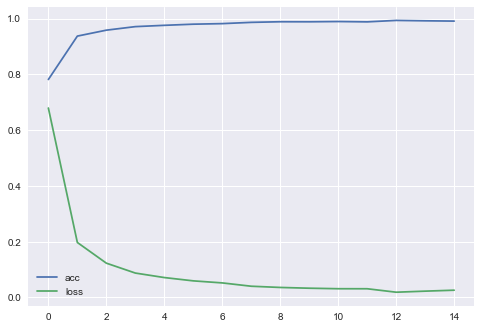

,loss,acc,val_loss,val_acc
0,0.679320,0.781639,0.188900,0.950149
1,0.197174,0.937241,0.120303,0.962054
2,0.122978,0.958506,0.097152,0.970238
3,0.087482,0.971214,0.073407,0.978423
4,0.071338,0.975882,0.079000,0.973958
5,0.059491,0.979985,0.102840,0.971726
6,0.052143,0.981976,0.071914,0.980655
7,0.040216,0.986515,0.069558,0.979911
8,0.035860,0.988719,0.056299,0.983631
9,0.033140,0.988589,0.058701,0.981399


In [10]:
plot_metrics(gen_history, ['acc', 'loss'])

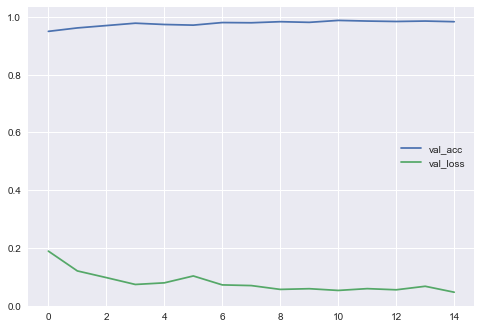

,loss,acc,val_loss,val_acc
0,0.679320,0.781639,0.188900,0.950149
1,0.197174,0.937241,0.120303,0.962054
2,0.122978,0.958506,0.097152,0.970238
3,0.087482,0.971214,0.073407,0.978423
4,0.071338,0.975882,0.079000,0.973958
5,0.059491,0.979985,0.102840,0.971726
6,0.052143,0.981976,0.071914,0.980655
7,0.040216,0.986515,0.069558,0.979911
8,0.035860,0.988719,0.056299,0.983631
9,0.033140,0.988589,0.058701,0.981399


In [11]:
plot_metrics(gen_history, ['val_acc', 'val_loss'])

In [12]:
# root = Path('.')  # Root Directory
# new_dir = Path('Numbers - OnlyResized')  # Resized images will be saved here

# if not new_dir.exists():  # If the path doesn't exist
#     new_dir.mkdir()  # Create a directory `Numbers - Resized`

# numbers = root / 'Numbers - Original'


# def resize(src_dir: Path, dest_dir: Path, size: Tuple = (40, 40), save_images=True, shuffle=True):
#     if not src_dir.exists():
#         print('Directory does not exist...\n Check path')
#         return -1
#     sub_dirs = [x for x in src_dir.iterdir() if x.is_dir()]

#     if not dest_dir.exists():
#         dest_dir.mkdir()
    
#     resized_images = []

#     for sub_dir in sub_dirs:
#         dest_subdir = dest_dir / sub_dir.name
#         if not dest_subdir.exists():
#             dest_subdir.mkdir()
#         for image_path in sub_dir.iterdir():
#             image = cv2.imread(str(image_path), cv2.IMREAD_GRAYSCALE)
#             resized_image = cv2.resize(image, size)
#             resized_image = centralize(resized_image)
#             resized_images.append(resized_image)
            
#             if save_images:
#                 dest_path = dest_subdir / image_path.name
#                 cv2.imwrite(str(dest_path), resized_image)
#     print(f'Images resized to {size} and stored in {dest_dir}')
#     num_images = len(resized_images)
    
#     dummy = np.ones((num_images // 9, 1))
#     labels = np.zeros((num_images // 9, 1))
#     for val in range(1, 9):
#         labels = np.vstack([labels, val * dummy])
    
#     resized_images = np.array(resized_images)
    
#     if shuffle:
#         indices = np.random.permutation(num_images)
#         resized_images = resized_images[indices] / 255.
#         labels = labels[indices]
    
#     return resized_images[..., np.newaxis], to_categorical(labels)


# X_train, y_train = resize(numbers, new_dir)

In [13]:
def prepare_data(src_dir: Path):
    if not src_dir.exists():
        print('Source Directory does not exist...\nCheck Path')
        return -1
    sub_dirs = [x for x in src_dir.iterdir() if x.is_dir()]
    images = []
    labels = np.array([]).reshape((0, 1))
    curr_img_label = 0
    for sub_dir in sub_dirs:
        num_images = 0
        for image_path in sub_dir.iterdir():
            if image_path.is_file():
                num_images += 1
                images.append(cv2.imread(str(image_path), cv2.IMREAD_GRAYSCALE))
        dummy = np.ones((num_images, 1)) * curr_img_label
        print(f'In Directory {sub_dir.name} NumImages = {num_images}')
        labels = np.vstack([labels, dummy])
        curr_img_label += 1
    images = np.array(images)
    images = images[..., np.newaxis]

    assert curr_img_label == 9
    assert len(images) == len(labels)
    return images, to_categorical(labels)


X_train, y_train = prepare_data(Path('Numbers - Resized'))
X_train = X_train / 255. 

In Directory Digit-1 NumImages = 939
In Directory Digit-2 NumImages = 990
In Directory Digit-3 NumImages = 926
In Directory Digit-4 NumImages = 933
In Directory Digit-5 NumImages = 980
In Directory Digit-6 NumImages = 979
In Directory Digit-7 NumImages = 903
In Directory Digit-8 NumImages = 964
In Directory Digit-9 NumImages = 960


In [14]:
X_train, X_test, y_train, y_test = train_test_split(X_train, y_train, test_size=0.05, random_state=42)

In [15]:
img_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['acc'])

img_history = img_model.fit(
    X_train, y_train, batch_size=64, epochs=15, 
    callbacks=[img_callbacks], validation_split=0.05
)

Epoch 1/15
121/121 [==============================] - 20s 163ms/step - loss: 1.1944 - acc: 0.6005 - val_loss: 0.1329 - val_acc: 0.9657
INFO:tensorflow:Assets written to: Models\img_model_best\assets
INFO:tensorflow:Assets written to: Models\img_model\assets
Epoch 2/15
121/121 [==============================] - 20s 165ms/step - loss: 0.1576 - acc: 0.9545 - val_loss: 0.0625 - val_acc: 0.9877
INFO:tensorflow:Assets written to: Models\img_model_best\assets
INFO:tensorflow:Assets written to: Models\img_model\assets
Epoch 3/15
121/121 [==============================] - 20s 166ms/step - loss: 0.0854 - acc: 0.9714 - val_loss: 0.0440 - val_acc: 0.9902
INFO:tensorflow:Assets written to: Models\img_model_best\assets
INFO:tensorflow:Assets written to: Models\img_model\assets
Epoch 4/15
121/121 [==============================] - 21s 170ms/step - loss: 0.0602 - acc: 0.9800 - val_loss: 0.0343 - val_acc: 0.9926
INFO:tensorflow:Assets written to: Models\img_model_best\assets
INFO:tensorflow:Assets writ

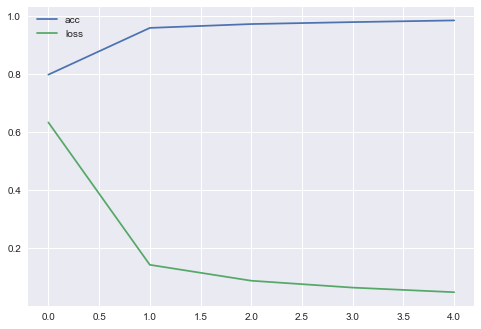

,loss,acc,val_loss,val_acc
0,0.632672,0.797337,0.132917,0.965686
1,0.141671,0.958511,0.062510,0.987745
2,0.086838,0.971824,0.043960,0.990196
3,0.063104,0.978545,0.034327,0.992647
4,0.047239,0.984361,0.015814,0.995098


In [16]:
plot_metrics(img_history, ['acc', 'loss'])

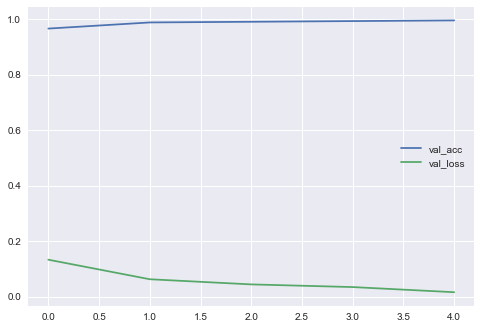

,loss,acc,val_loss,val_acc
0,0.632672,0.797337,0.132917,0.965686
1,0.141671,0.958511,0.062510,0.987745
2,0.086838,0.971824,0.043960,0.990196
3,0.063104,0.978545,0.034327,0.992647
4,0.047239,0.984361,0.015814,0.995098


In [17]:
plot_metrics(img_history, ['val_acc', 'val_loss'])

In [18]:
img_model.evaluate(X_train, y_train)

255/255 [==============================] - 3s 12ms/step - loss: 0.0183 - acc: 0.9955


[0.01826298236846924, 0.9954573512077332]

In [19]:
gen_model.evaluate(X_train, y_train)

255/255 [==============================] - 4s 14ms/step - loss: 0.0552 - acc: 0.9854


[0.05522170290350914, 0.9853898286819458]

GenModel : 2
ImgModel : 2


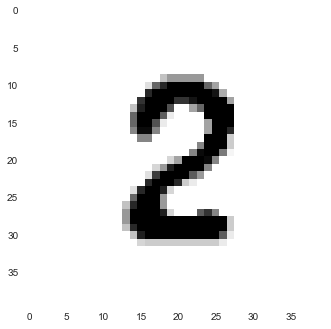

GenModel : 5
ImgModel : 5


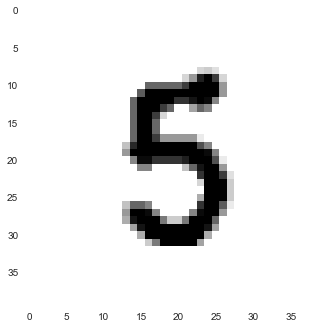

GenModel : 1
ImgModel : 7


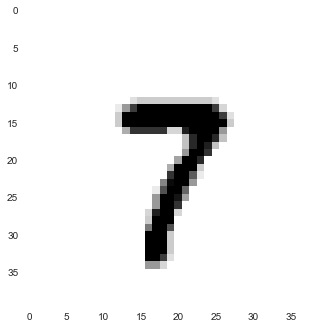

GenModel : 6
ImgModel : 6


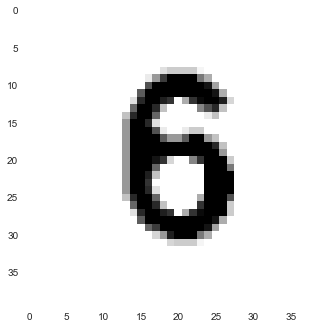

GenModel : 1
ImgModel : 1


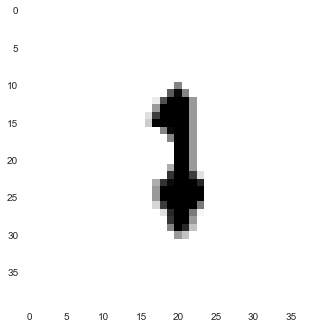

GenModel : 9
ImgModel : 9


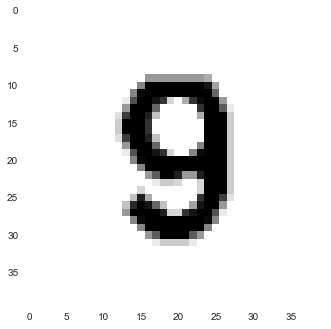

GenModel : 6
ImgModel : 6


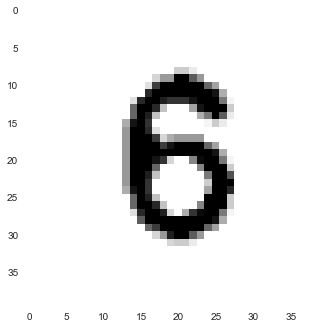

GenModel : 2
ImgModel : 2


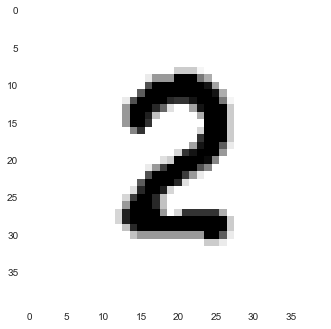

GenModel : 9
ImgModel : 8


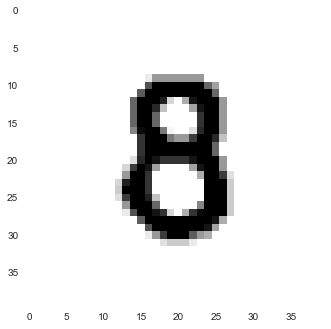

GenModel : 4
ImgModel : 4


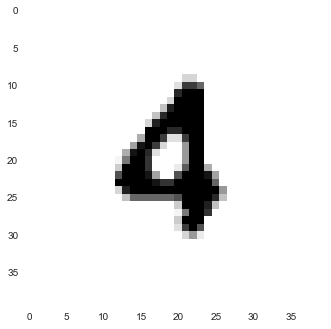

GenModel : 5
ImgModel : 5


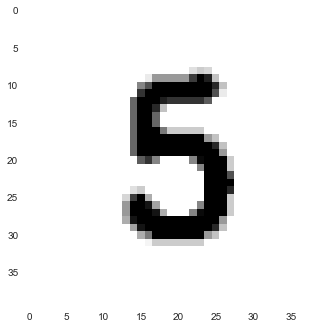

GenModel : 9
ImgModel : 9


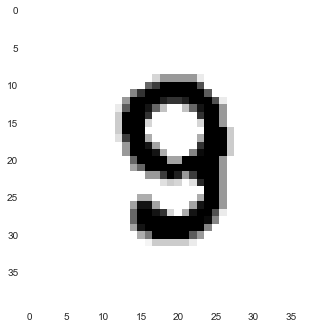

GenModel : 8
ImgModel : 8


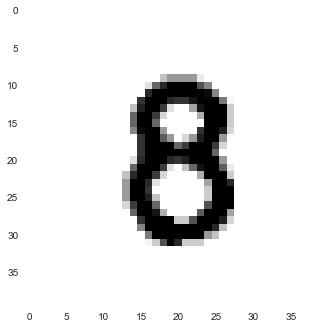

GenModel : 1
ImgModel : 7


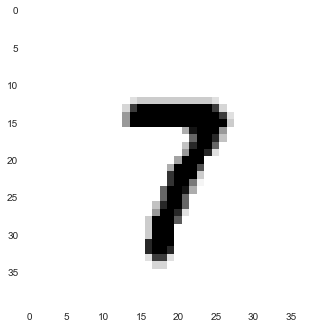

GenModel : 4
ImgModel : 4


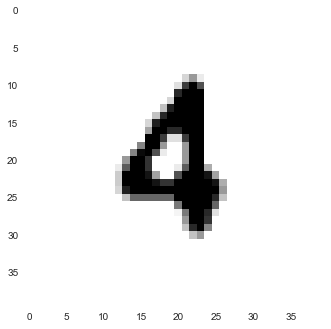

GenModel : 5
ImgModel : 5


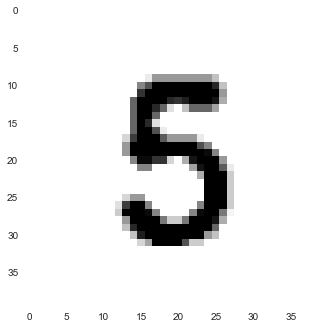

GenModel : 1
ImgModel : 7


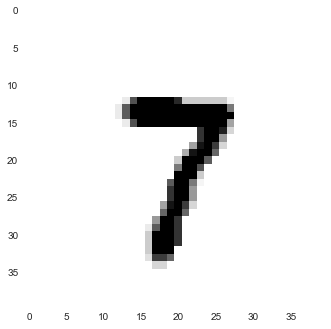

GenModel : 6
ImgModel : 8


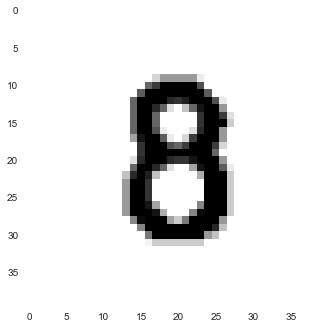

GenModel : 2
ImgModel : 2


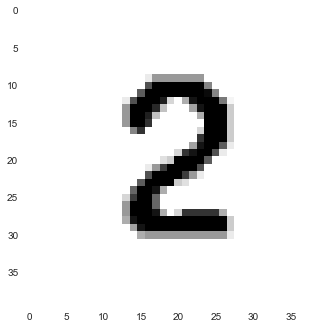

GenModel : 6
ImgModel : 6


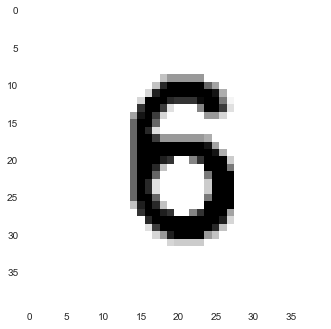

GenModel : 9
ImgModel : 9


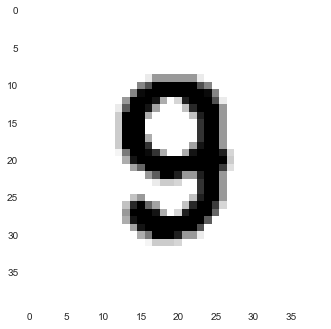

GenModel : 6
ImgModel : 6


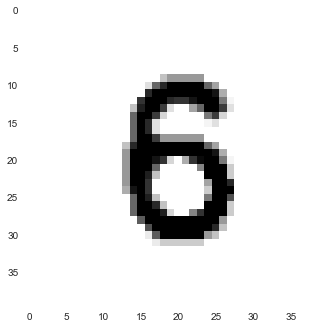

GenModel : 3
ImgModel : 3


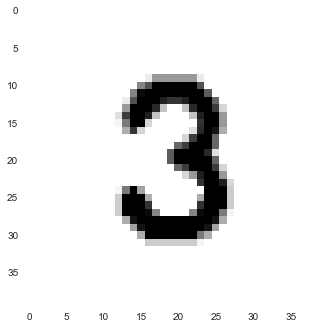

GenModel : 5
ImgModel : 5


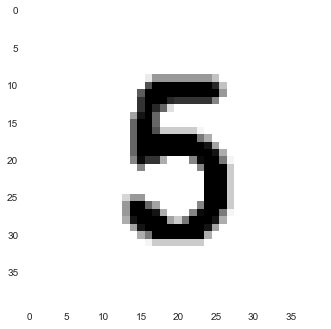

GenModel : 1
ImgModel : 7


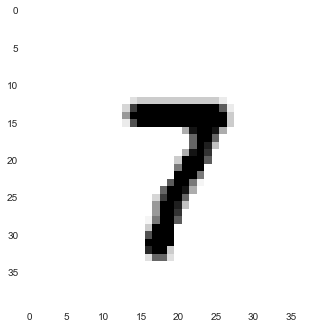

GenModel : 1
ImgModel : 7


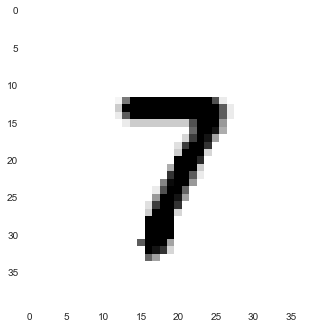

GenModel : 5
ImgModel : 5


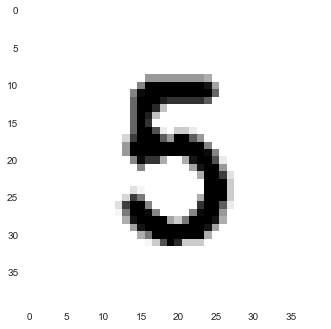

GenModel : 2
ImgModel : 2


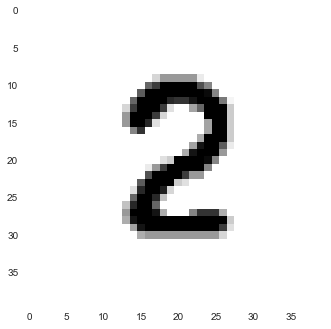

GenModel : 6
ImgModel : 6


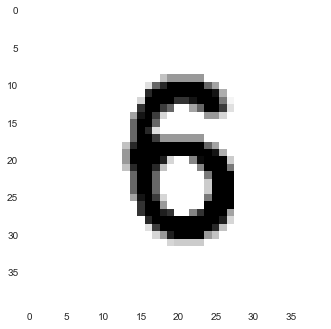

GenModel : 5
ImgModel : 5


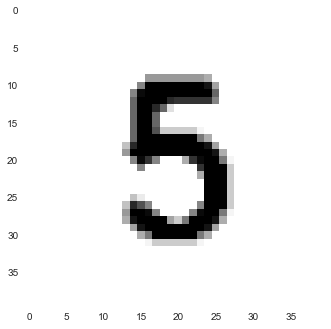

GenModel : 1
ImgModel : 1


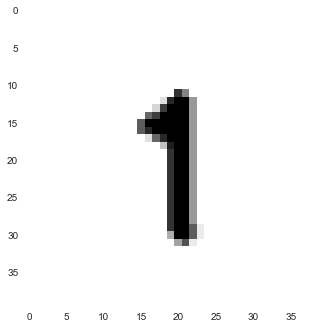

GenModel : 2
ImgModel : 2


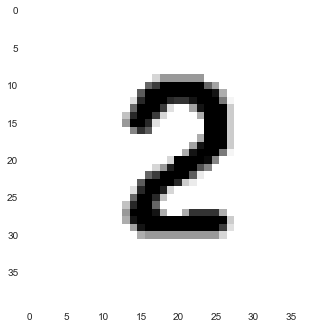

GenModel : 3
ImgModel : 3


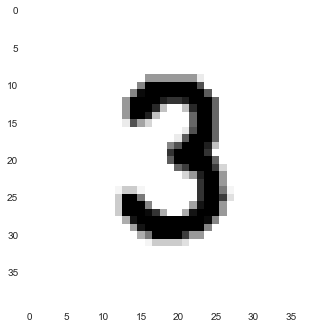

GenModel : 4
ImgModel : 4


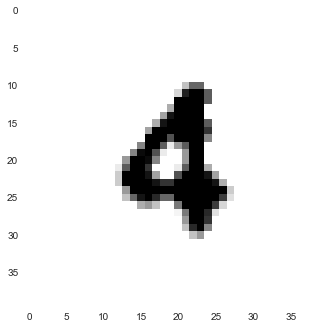

GenModel : 5
ImgModel : 5


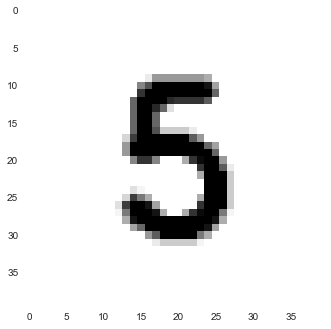

GenModel : 6
ImgModel : 8


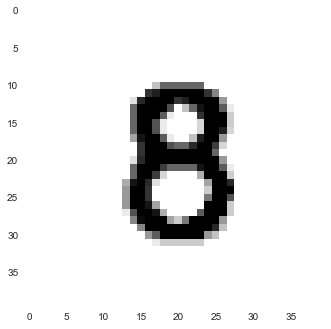

In [22]:
test_path = Path('./Extracted-2')
digits = [0, 2, 5, 8, 9, 12, 13, 16, 22, 25, 26, 27, 28, 31, 32, 36, 37, 
          39, 41, 43, 44, 48, 49, 52, 53, 54, 55, 58, 64, 67, 68, 71, 72, 75, 78, 80]
for i in digits:
    image = cv2.imread(str(test_path / f'{i}.png'), cv2.IMREAD_GRAYSCALE)
    image = image / 255.
    plt.imshow(image, cmap='gray')
    plt.grid(False)
    image = image[np.newaxis, ..., np.newaxis]
    print(f'GenModel : {np.argmax(gen_model.predict(image))+1}')
    print(f'ImgModel : {np.argmax(img_model.predict(image))+1}')
    plt.show()